# JSC Assignment 2: ~Soccer~ Football!




# Introduction

## Value Added and Measures of Success

For this assignment we are assuming the roles of data scientists at a football club. The goal of this assignment is to develop models which are able to accurately predict the probability of a shot resulting in a goal. Such successful models could be a great tool for measuring the quality of chances the team is performing, and also provide insights into what sort of chances the team should attempt to create. Likewise, such models could enable the team to understand their opponents’ threats better. On an individual level, this insight can also assist in player development as players’ training should focus on the situations that suit the player and are most likely to benefit the team.

Ultimately, the impact of the models should be to enable the team to win games and trophies. The team’s performance can further be evaluated by various statistics such as goals scored per game, points won per game, shot success rate, etc., however we would expect it to be very difficult to precisely understand the impact of our models on the team’s performance, as performance is dependent on uncountably many factors. Football is often touted as an unpredictable -- unquantifiable -- game, so we may have to rely on qualitative feedback from coaches and players on the value of our models. 

Still, one way to quantify the value of our models could be to compare it to the [Expected Goals metric (xG)](https://www.optasports.com/services/analytics/advanced-metrics/), the recently introduced state of the art metric of data science in football, which also provides the probability of a shot resulting in a goal. xG attempts to account for many variables such as the ones present in our dataset, but also more dynamic factors such as the positioning of players around the ball. xG is meant to give the probability of the shot resulting in a goal if it was taken by the “average” player, and has proven to be very accurate. Thus, we should aim to match our predictions to those of xG, or even beat them if we include more specific information such as player information which should allow for more precise predictions than those for the “average” player.



# Exploratory Data Analysis

### Imports

In [ ]:
# Data originally from https://www.kaggle.com/secareanualin/football-events
# Related analysis at https://www.kaggle.com/gabrielmanfredi/expected-goals-player-analysis

!wget https://jsc370.github.io/events.csv.zip
!unzip events.csv.zip

!wget https://jsc370.github.io/ginf.csv.zip
!unzip ginf.csv.zip

!wget https://jsc370.github.io/dictionary.txt


--2021-02-18 00:46:21--  https://jsc370.github.io/events.csv.zip
Resolving jsc370.github.io (jsc370.github.io)... 185.199.108.153, 185.199.109.153, 185.199.110.153, ...
Connecting to jsc370.github.io (jsc370.github.io)|185.199.108.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 21797089 (21M) [application/zip]
Saving to: ‘events.csv.zip’

events.csv.zip      100%[===================>]  20.79M  96.8MB/s    in 0.2s    

2021-02-18 00:46:22 (96.8 MB/s) - ‘events.csv.zip’ saved [21797089/21797089]

Archive:  events.csv.zip
  inflating: events.csv              
--2021-02-18 00:46:24--  https://jsc370.github.io/ginf.csv.zip
Resolving jsc370.github.io (jsc370.github.io)... 185.199.108.153, 185.199.109.153, 185.199.110.153, ...
Connecting to jsc370.github.io (jsc370.github.io)|185.199.108.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 344339 (336K) [application/zip]
Saving to: ‘ginf.csv.zip’

ginf.csv.zip        100%[================

In [ ]:
import pandas as pd
import jax.numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, balanced_accuracy_score
from sklearn.metrics import f1_score, auc, precision_score, recall_score
import numpy as onp


import jax.numpy as jnp
import numpy.random as npr
from jax.api import jit, grad

plt.rcParams["figure.figsize"] = (15, 10)
plt.style.use("seaborn")

### Reading Data

In [ ]:
events = pd.read_csv('events.csv')
info = pd.read_csv('ginf.csv')

In [ ]:
# considering data from particular event ( " 1 = Attempt to shot")
shots = events[events.event_type==1]

### Exploratory Data Analysis

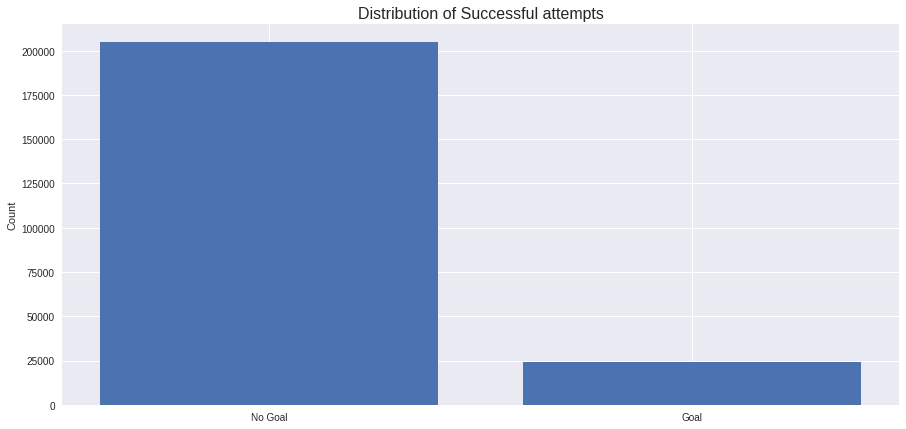

In [ ]:
plt.rcParams["figure.figsize"] = (15, 7)
plt.bar(["No Goal", "Goal"], shots["is_goal"].value_counts())
plt.title("Distribution of Successful attempts", fontsize=16)
plt.ylabel("Count")
plt.show()

There is a clear target imbalance in our data: the large majority of shots do not result in goals. We expect this to be one of the main problems for developing models and we should aim to mitigate this issue.

In [ ]:
num_teams = shots["event_team"].nunique()
num_players = shots["player"].nunique()

print(f"There are {num_teams} unique teams in the dataset.")
print(f"There are {num_players} players in the dataset.")

There are 142 unique teams in the dataset.
There are 4787 players in the dataset.


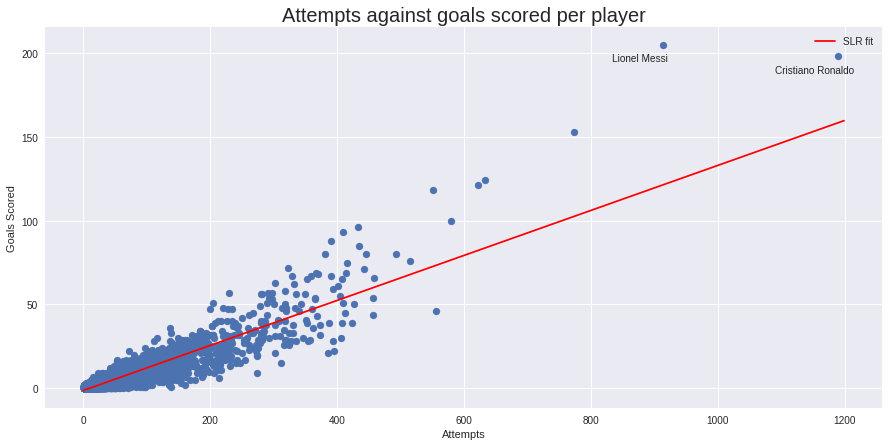

In [ ]:
attempts = shots["player"].value_counts().sort_index()
goals = shots.groupby("player")["is_goal"].sum().sort_index()
m, b = onp.polyfit(attempts, goals, deg=1)
plt.scatter(attempts, goals) # alpha = 0.5
plt.title("Attempts against goals scored per player", fontsize=20)
plt.xlabel("Attempts")
plt.ylabel("Goals Scored")
plt.plot(onp.arange(1200), (onp.arange(1200)*m) + b, label="SLR fit", color="red") # Diff color
plt.legend()

plt.text(attempts["cristiano ronaldo"]-100, goals["cristiano ronaldo"]-10, 
         "Cristiano Ronaldo")
plt.text(attempts["lionel messi"] - 80, goals["lionel messi"]-10, 
         "Lionel Messi")
plt.show()

To no one's surprise, shooting more correlates with scoring more. Still, we see that not all players are alike and there are players who clearly overperform and underperform the trend.

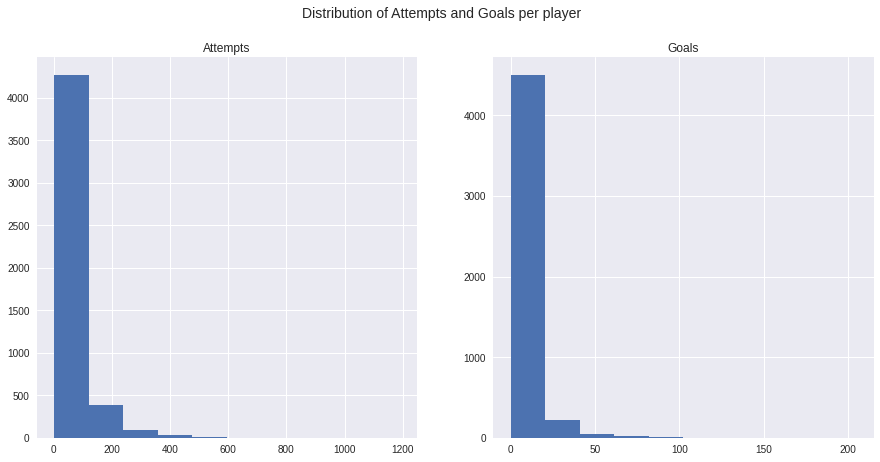

In [ ]:
fig, ax = plt.subplots(1, 2)
ax[0].hist(attempts)
ax[1].hist(goals)
ax[0].set_title("Attempts")
ax[1].set_title("Goals")
fig.suptitle("Distribution of Attempts and Goals per player", fontsize=14)
plt.show()

The large majority of players have fewer than 200 attempts to their name, while on the goals side most have fewer than 50 goals.


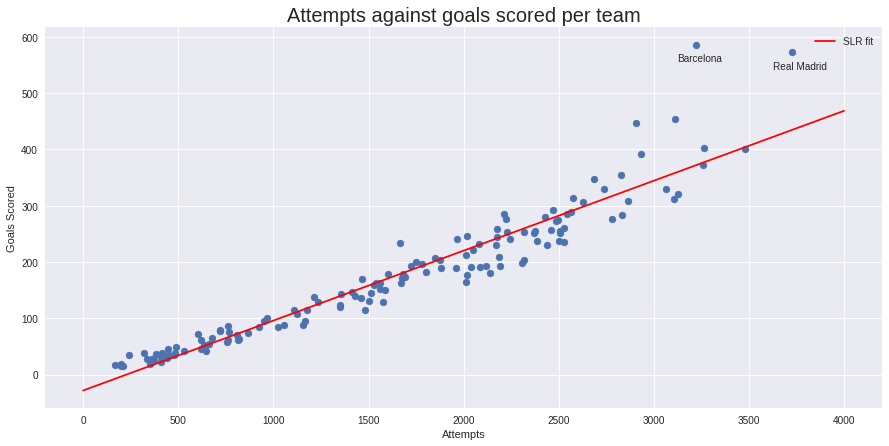

In [ ]:
team_attempts = shots["event_team"].value_counts().sort_index()
team_goals = shots.groupby("event_team")["is_goal"].sum().sort_index()
m, b = onp.polyfit(team_attempts, team_goals, deg=1)
plt.scatter(team_attempts, team_goals)
plt.title("Attempts against goals scored per team", fontsize=20)
plt.xlabel("Attempts")
plt.ylabel("Goals Scored")
plt.plot(onp.arange(4000), (onp.arange(4000)*m) + b, label="SLR fit", color="red")
plt.legend()

plt.text(team_attempts["Barcelona"]- 100, team_goals["Barcelona"]-30, 
         "Barcelona")
plt.text(team_attempts["Real Madrid"] -100, team_goals["Real Madrid"]-30, 
         "Real Madrid")

plt.show()

The picture is similar for when we look at shots and goals per team: there is a positive linear relationship, but the outliers are not as extreme. We can also notice that the two greatest outliers, Barcelona and Real Madrid, are the teams the two most outlying players, Lionel Messi and Cristiano Ronaldo respectively have played for.

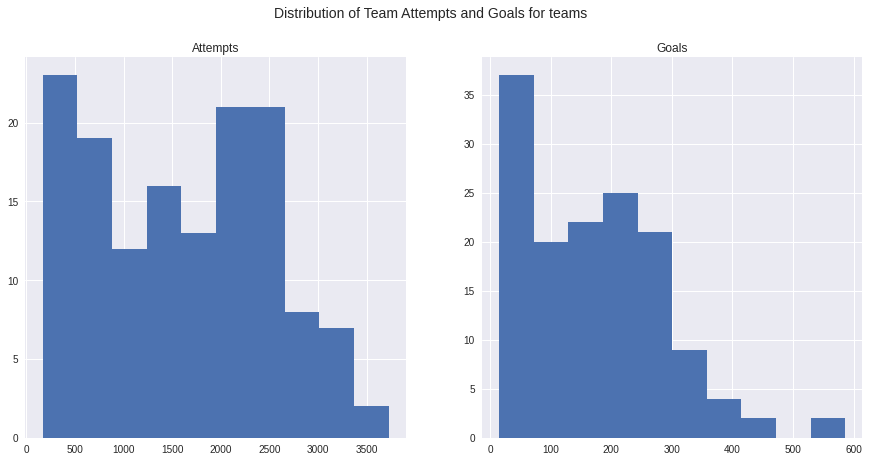

In [ ]:
fig, ax = plt.subplots(1, 2)
ax[0].hist(team_attempts)
ax[1].hist(team_goals)
ax[0].set_title("Attempts")
ax[1].set_title("Goals")
fig.suptitle("Distribution of Team Attempts and Goals for teams", fontsize=14)
plt.show()

There seems to be a bimodal distribution for both team attempts and goals, and neither measurement is as narrowly distributed as it was for players. 

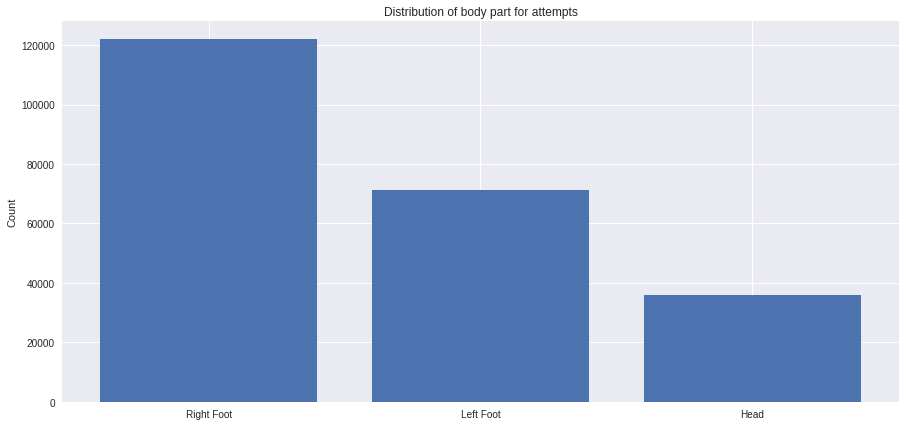

In [ ]:
plt.bar(["Right Foot", "Left Foot", "Head"],
        shots["bodypart"].value_counts())

plt.ylabel("Count")
plt.title("Distribution of body part for attempts")

plt.show()

Most players are right-footed, so it is no surprise that this is the body part shots are most frequently taken with. Headers are less frequent than shots with feet.

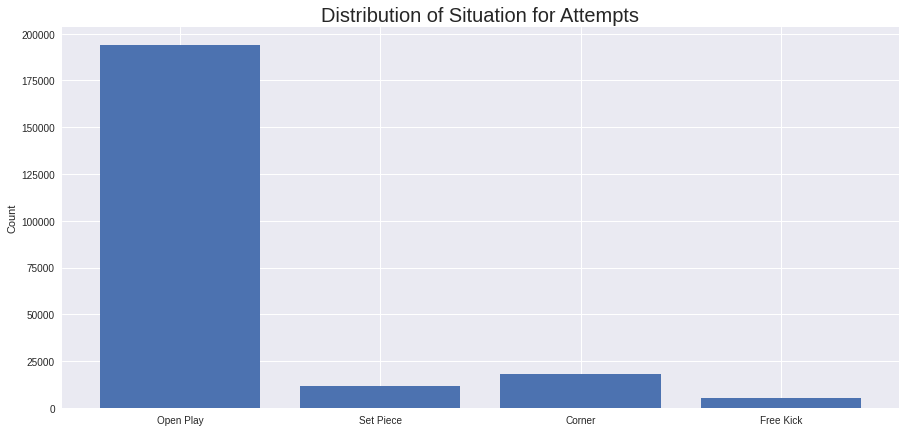

In [ ]:
plt.bar(["Open Play", "Set Piece", "Corner", "Free Kick"],
        shots["situation"].value_counts().sort_index())

plt.ylabel('Count')
plt.title("Distribution of Situation for Attempts", fontsize=20)
plt.show()

Most attempts result from open play. Corners are the most common dead-ball attempts.

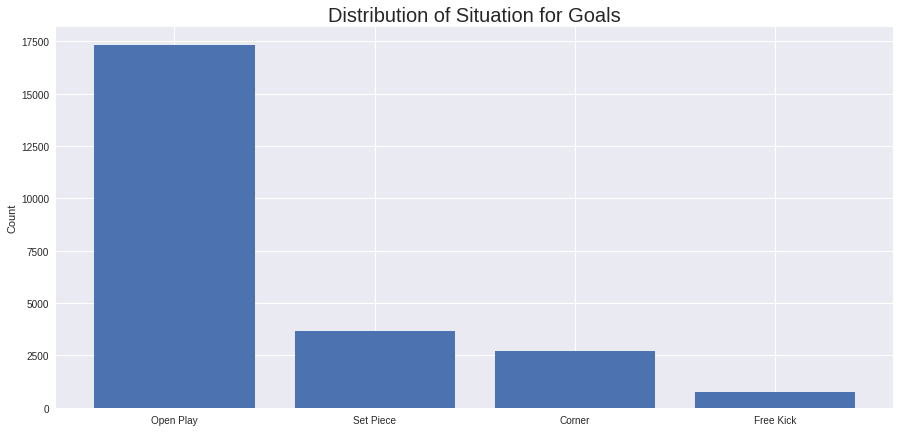

In [ ]:
plt.bar(["Open Play", "Set Piece", "Corner", "Free Kick"],
        shots[shots["is_goal"] == 1]["situation"].value_counts().sort_index())

plt.ylabel('Count')
plt.title("Distribution of Situation for Goals", fontsize=20)
plt.show()

The frequency of goals per situation is similar: it is dominated by open play goals. However, we see that set pieces result in goals more frequently than corners, whereas there were more goal attempts from corners rather than set pieces.

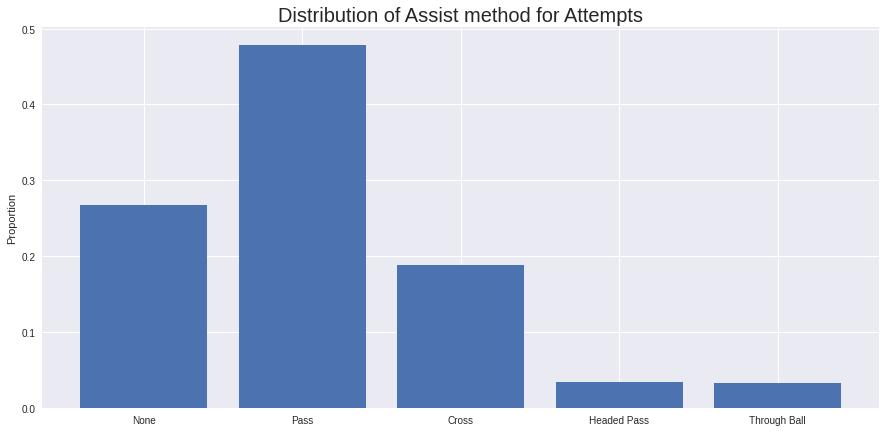

In [ ]:
plt.bar(["None", "Pass", "Cross", "Headed Pass", "Through Ball"],
        shots["assist_method"].value_counts(normalize=True).sort_index())
plt.ylabel("Proportion")
plt.title("Distribution of Assist method for Attempts", fontsize=20)
plt.show()

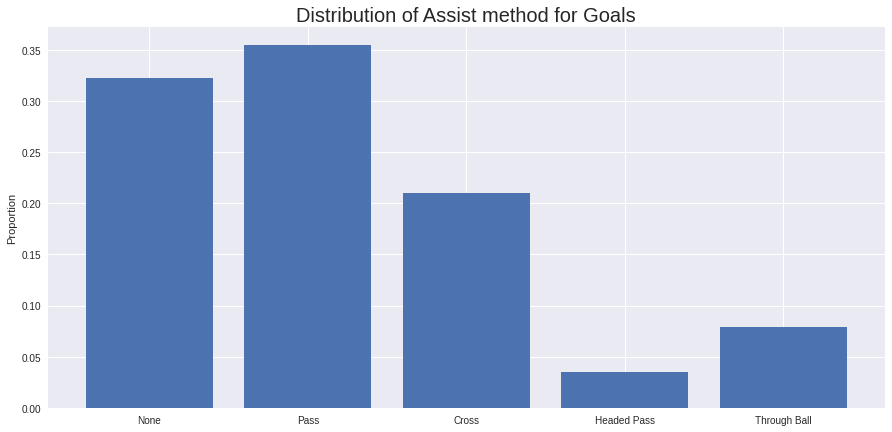

In [ ]:
plt.bar(["None", "Pass", "Cross", "Headed Pass", "Through Ball"],
        shots[shots["is_goal"] == 1]["assist_method"].value_counts(
            normalize=True).sort_index())
plt.ylabel("Proportion")
plt.title("Distribution of Assist method for Goals", fontsize=20)
plt.show()

We can see that far fewer attempts without an assist succeed compared to other assist methods. Moving the ball around (i.e. passing it) opens up more space and hence makes shot conversion easier.

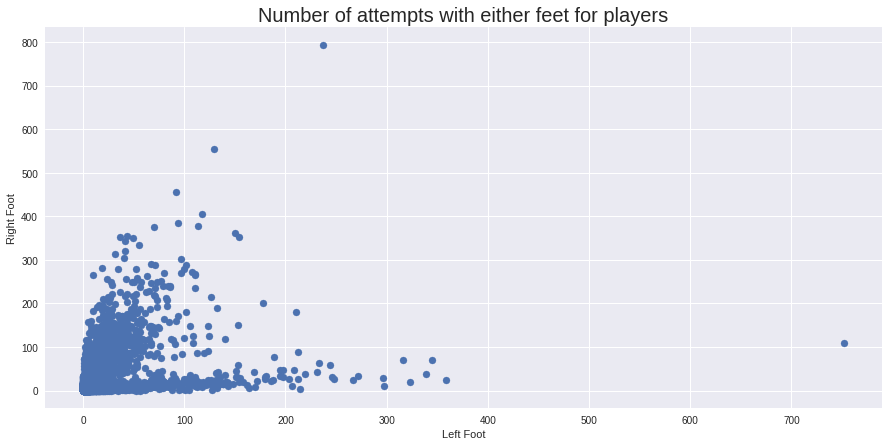

In [ ]:
num_right_foot = pd.DataFrame(shots[shots["bodypart"] == 1].groupby("player").size()).reset_index()
num_left_foot = pd.DataFrame(shots[shots["bodypart"] == 2].groupby("player").size()).reset_index()

num_right_foot = num_right_foot.rename(columns={0: "Num_Right"})
num_left_foot = num_left_foot.rename(columns={0: "Num_Left"})

num_both = num_left_foot.join(num_right_foot.set_index("player"), on="player", how="outer")
num_both = num_both.fillna(0)
plt.scatter(num_both["Num_Left"], num_both["Num_Right"])
plt.xlabel("Left Foot"), plt.ylabel("Right Foot")
plt.title("Number of attempts with either feet for players", fontsize=20)
plt.show()

The majority of players are right-footed, but there are still many who tend to shoot with their left foot. Players lying on the $y = x$ line can be considered ambidextrous

### Preparing data
We decided to use all the features in the dataset. (The worry that one of the features was an encoding for goal was due to a bug in the data creation). We have also decided to drop the "no location recorded", as it has no useful information.

We assigned each player their own unique player id that will be used to distinguish between players. 

To counter the imbalanced data, we have decided to perform oversampling on the dataset. We have made it so that roughly 25% of the dataset are goals, and the rest are non goals.

In [ ]:
player_ids, id_to_player = pd.factorize(shots["player"])

In [ ]:
id_to_player = {i: player for i, player in enumerate(id_to_player.to_list())}
player_to_id = {player: id for id, player in id_to_player.items()}

In [ ]:
# one-hot encoding (binary representation of fature values)

data = pd.get_dummies(shots[["is_goal","bodypart","situation", "assist_method"]], 
                      columns=['bodypart', 'situation', "assist_method"])
data.columns =  ['is_goal','right_foot', 'left_foot', 
                 'header', 'open_play', 'set_piece', 'corner', 
                 'free_kick', "assist_none", "assist_pass", "assist_cross",
                 "assist_headed_pass", "assist_trough_ball"]
data["player_id"] = player_ids

In [ ]:
# one-hot encoding (binary representation of fature values)

data = pd.get_dummies(shots.iloc[:,-5:], columns=['location', 'bodypart','assist_method', 'situation'])
data.columns = ['fast_break', 'loc_centre_box', 'loc_diff_angle_lr', 'diff_angle_left', 'diff_angle_right',
                'left_side_box', 'left_side_6ybox', 'right_side_box', 'right_side_6ybox', 'close_range',
                'penalty', 'outside_box', 'long_range', 'more_35y', 'more_40y', 'not_recorded', 'right_foot', 
                'left_foot', 'header', 'no_assist', 'assist_pass', 'assist_cross', 'assist_header',
                'assist_through_ball', 'open_play', 'set_piece', 'corner', 'free_kick']

data['is_goal'] = shots['is_goal']
data["player_id"] = player_ids
# Drop no recorded location
# data = data[data["not_recorded"] != 1]
data = data.drop(columns=["not_recorded"])

In [ ]:
# Oversampling

additional_data = data[data["is_goal"] == 1].sample(n=data.shape[0]//5,
                                                    replace=True)

data = pd.concat([data, additional_data])

In [ ]:
print("Total dataset size: ", len(data))
print("Num goals: ", data.is_goal.sum())
print("Ratio of positive samples: ", data["is_goal"].sum() / data.shape[0])
print("Ratio of negative samples: ", 
      (data.shape[0] - data["is_goal"].sum())/data.shape[0])
print("Number of features: ",len(data.columns)-1)

Total dataset size:  274962
Num goals:  70268
Ratio of positive samples:  0.2555553130978099
Ratio of negative samples:  0.7444446869021901
Number of features:  28


In [ ]:
# train test split and format data.
X = data.drop(["is_goal"],axis =1)
y = data["is_goal"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_train = np.float32(np.array(X_train))
X_test = np.float32(np.array(X_test))
y_train = np.float32(np.array(y_train))
y_test = np.float32(np.array(y_test))

c_train = np.ones((X_train.shape[0], 1))               # intercept 
X_train_full = np.concatenate((c_train, X_train), axis=1)   # Add intercept to the original feature set
c_test = np.ones((X_test.shape[0], 1)) 
X_test_full = np.concatenate((c_test, X_test), axis=1)


X_train, player_ids_train = X_train_full[:, :-1], X_train_full[:, -1]
X_test, player_ids_test = X_test_full[:, :-1], X_test_full[:, -1]


# Brainstorming

## Complementary sources of data

There is definitely so much more that affects the probability of a shot ending in a goal than what is present in our dataset. Including the injury history of players in our models could improve them, as recurring or severe injuries affect a player’s ability to perform certain movements. Player’s ability is most definitely not constant, and so long-term information about a player could be complemented with a time-series dataset which would enable our models to account for recent form. There is definitely a lot to be squeezed out of our present dataset too with knowledgeable feature engineering: for example, rather than separately looking at whether a shot was taken with a left or right foot, we could determine if the player used their preferred foot by looking at the proportion of shots they take with either foot.

More creative ways to obtain additional data include looking at football video games, which often provide attributes for different aspects of the game for players - often including a shooting ability attribute. Video games such as Football Manager are known for having an actual scouting network that go to football matches in person to evaluate players, so this data may prove to be very insightful. One main research area of data science in football is using computer vision to understand the dynamics of football using video: models utilizing this data could perform much better than the ones available now if they manage to capture new aspects of the game.



## All factors

Football is by no means a simple game, and what happens on the pitch is dependent on uncountably many factors. While football is played in teams of 11 players, there is often talk about the 12th man - the fans, whose support (or voicement of dissatisfaction) can have great impacts on the game. Weather can have tremendous effects on the game as the condition of the pitch can drastically change the way the ball and the players move.

Matches of football are most definitely not independent. Teams’ and players’ form carries over from one game to another: hot streaks can be very difficult for opponents to stop, while teams’ and players’ performances can struggle for long periods when stuck in a slump. This can further be impacted by aspects such as the number of rest days since the previous game, or the distance the away team had to travel for the match, as travel fatigue can have a significant impact on performances. Furthermore, there are many psychological aspects to be considered: for example, media pressure, as the media is very involved in the world’s most popular sport. There is an unexplainable “magic” to derby matches, where players can often find unseen levels of ability. Large sum transfers and contracts are a big part of football too, and so players may see their motivation levels change if they are keen on a bigger contract at another club.




# Model Staircase


We propose the following model staircase: 

### Model 1 (Baseline):

Random choice from $X \sim Bern(\theta)$ where $\theta$ represents the proportion of number of goals scored per player. If the player is not recorded, choose from $X \sim Bern(0.5)$

### Model 2: 
Simple logistic regression

### Model 3: 
Simple logistic regression with bias added for each player (We add all the players as a one-hot variable)

### Model 4: 
Logitboost

### Model 5: 

Latent Variable Model, where each player is assigned a "score" for each feature.


There will be further detail for the extensions in the Model Creation segment.

# Model Creation

### Utility Functions

In [ ]:
def evaluate(true, predictions):

  acc = accuracy_score(true, predictions)
  bal_acc = balanced_accuracy_score(true, predictions)

  print(f"Accuracy: {acc}")
  print(f"Balanced Accuracy: {bal_acc}")
  print(classification_report(true, predictions))

def get_metrics(true, predictions):

  acc = accuracy_score(true, predictions)
  bal_acc = balanced_accuracy_score(true, predictions)
  f1 = f1_score(true, predictions)
  prec = precision_score(true, predictions)
  rec = recall_score(true, predictions)

  return acc, bal_acc, prec, rec, f1 

## Model 1: Bernoulli per player

Random choice from $X \sim Bern(\theta)$ where $\theta$ represents the proportion of number of goals scored per player. If the player is not recorded, choose from $X \sim Bern(0.5)$

In [ ]:
goals = pd.Series(X_train_full[y_train == 1][:, -1]).value_counts().sort_index()
attempts = pd.Series(X_train_full[:, -1]).value_counts().sort_index()
theta_1 = onp.full(num_players, fill_value=0.5)
probs = (goals/attempts).fillna(0)
theta_1[probs.index.to_numpy().astype(int)] = probs.values

In [ ]:
def bern_predict(theta, X):
  indexes = X[:, -1].astype(int)
  preds = onp.random.uniform(size=indexes.shape[0]) <= theta[indexes]
  return preds


In [ ]:
preds = bern_predict(theta_1, X_test_full)
evaluate(y_test, preds)

Accuracy: 0.6417544051061044
Balanced Accuracy: 0.5310997895030838
              precision    recall  f1-score   support

         0.0       0.76      0.76      0.76     40925
         1.0       0.30      0.30      0.30     14068

    accuracy                           0.64     54993
   macro avg       0.53      0.53      0.53     54993
weighted avg       0.64      0.64      0.64     54993



## Model 2: Simple Logistic Regression

Logistic regression in its vanilla form. The model outputs the probability of a goal for a shot, and a 0.5 threshold is used to determine whether the prediction corresponds to a goal or not.

In [ ]:
# Simple logistic regression model.

from jax.api import vmap   # Takes a function that operates on a single
                           # example, and vectorizes it to work on a batch.
from tqdm.auto import tqdm

epochs = 100
learning_rate = 1

theta_2 = np.zeros(X_train.shape[1])       # initialize weights 

def sigmoid(z):
  return 1.0 / (1.0 + np.exp(-z))

def logreg_pred(params, X):
  return sigmoid(np.dot(X, params))

def log_bernoulli(y, p):
  return np.mean(y * np.log(p) + (1.0 - y) * np.log(1.0 - p))

def single_loss(params, X, y):
  return -log_bernoulli(y, logreg_pred(params, X))

def batch_loss(params, X, y):
  vectorized_logprob = vmap(single_loss, (None, 0, 0))  # Vectorize over X and y.
  return np.mean(vectorized_logprob(params, X, y))

def accuracy(params, x, y, threshold=0.5):
  preds = logreg_pred(params, x)
  preds = preds >= threshold

  return accuracy_score(y, preds)

# print(grad(batch_loss)(theta, X_train, y_train))

train_loss = [] # loss history 
train_accuracies = []
test_accuracies = []

for i in tqdm(range(epochs)):
  theta_2 = theta_2 - learning_rate * grad(batch_loss)(theta_2, X_train, y_train)
  loss_tr = batch_loss(theta_2, X_train, y_train)
  train_loss.append(loss_tr)
  train_accuracy = accuracy(theta_2, X_train, y_train)
  test_accuracy = accuracy(theta_2, X_test, y_test)

  train_accuracies.append(train_accuracy)
  test_accuracies.append(test_accuracy)
  # print(i, loss_tr, np.mean(train_accuracy), np.mean(test_accuracy))


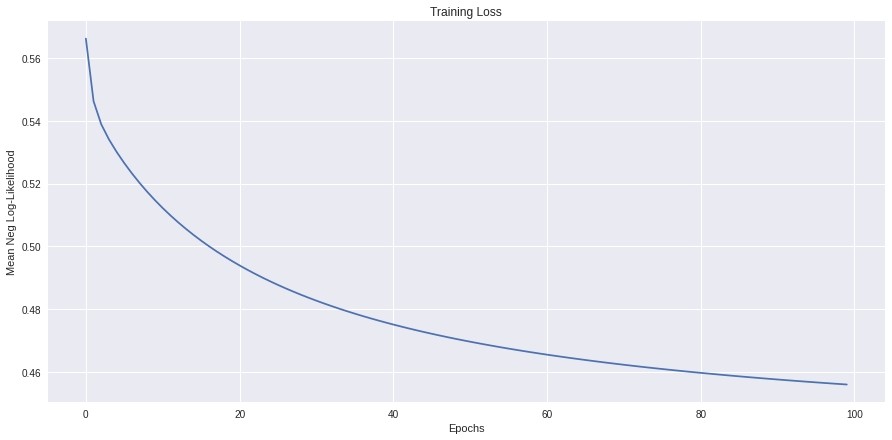

In [ ]:
plt.plot(onp.arange(epochs), train_loss)
plt.title("Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Mean Neg Log-Likelihood")
plt.show()

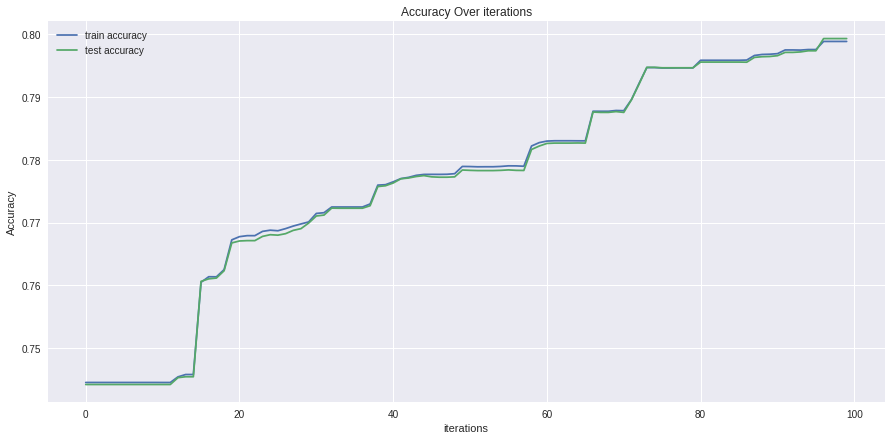

In [ ]:
plt.plot(onp.arange(epochs), train_accuracies, label="train accuracy")
plt.plot(onp.arange(epochs), test_accuracies, label="test accuracy")
plt.title("Accuracy Over iterations")
plt.ylabel("Accuracy")
plt.xlabel("iterations")
plt.legend()

plt.show()

## Model 4: LogitBoost

As was discussed previously, there is target imbalance in the data. We can attempt to mitigate the issue by boosting logistic regression models. That is, we train multiple logistic regression models and focus the next model on the training examples that the previous one performed poorly on.

This model is developed based on Friedman, J., Hastie, T., Tibshirani, R. (2000). Additive logistic regression: a statistical view of boosting. https://projecteuclid.org/euclid.aos/1016218223. The reference for the model can be found on page 351.

In essence, LogitBoost is AdaBoost adapted for logistic regression. LogitBoost revolves around using weighted least squares regressors to minimize the log-likelihood $z = \frac{y^* - p(x)}{p(x)(1 - p(x))}$ where $y^* = \frac{y + 1}{2}$ and $p(x) = p(y^* = 1 | x)$. Note that $y \in \{-1, 1\}$ for convenience.

In [ ]:
import numpy as onp
# Importing linear regression object for convenience here
from sklearn.linear_model import LinearRegression

# Replace negative targets with -1 for convenience
y_train_alt = onp.copy(y_train)
y_train_alt[y_train_alt == 0] = -1


def predict_logitboost(X, classifiers):
  """
  Predictions given by sign(F(X)) = sign(SUM{ f(X) })
  """
  X = onp.array(X)
  preds = np.array([mod.predict(X) for mod in classifiers])
  return np.sign(np.sum(preds, axis=0))

def logitboost_accuracy(X, y, classifiers):
  preds = predict_logitboost(X, classifiers)
  y_alt = onp.copy(y)
  y_alt[y_alt == 0] = -1
  return accuracy_score(preds, y_alt)


def train_logitboost(X, y, epochs, learning_rate=0.05, X_test=None, y_test=None,
                     eval_freq=20):
  """
  Developed based on Friedman, J., Hastie, T., Tibshirani, R. (2000).
  Additive logistic regression: a statistical view of boosting.
  https://projecteuclid.org/euclid.aos/1016218223

  Algorithm reference can be found on p. 351.
  """
  # sklearn can't handle JAX arrays sometimes
  X = onp.array(X)
  if X_test is not None:
    X_test = onp.array(X_test)

  # Initialize sample weights to 1/N. Not sure why the paper says to do this ¯\_(ツ)_/¯
  weights = np.full((X.shape[0], ), 1/X.shape[0])
  # Initialize p(x_i) = 0.5
  probs = np.full((X.shape[0], ), 0.5)

  # Essentially the model F
  classifiers = []
  # F(X) = sum(f(X)) for every weak learner
  preds = np.zeros((X.shape[0], ))

  # Train, test accuracies for plotting
  train_accs = []
  test_accs = []

  # Used every iteration for computing z
  y_star = (y + 1)/2

  for i in tqdm(range(epochs)):

    # Newton-Raphson approximator of the minimizer of the log-likelihood
    z = onp.array((y_star - probs)/(probs*(1 - probs)))
    # z can explode in value, so for numerical stability limit it to [-3, 3]
    z[z > 3] = 3
    z[z < -3] = -3

    # Compute weights to use
    # According to this forum post, the weight update in the paper is wrong:
    # https://forums.pentaho.com/threads/73760-LogitBoost-implementation/
    weights = onp.array((y_star - probs) / z)
    # weights may get very small, causing numerical instability, so use random
    # small value to fix
    weights[weights < 0.000000000002] = 0.000000000002

    # Weighted least-squares regression on z
    #print(probs)
    #print(weights)
    func = LinearRegression().fit(X, z, weights)

    # Update F <- F + 0.5 f. Note that for final predictions 0.5 scalar does not matter
    classifiers.append(func)
    # F(X) evaluated
    preds += 0.5 * learning_rate * func.predict(X)

    # Gather accuracies for plotting
    if i % eval_freq == 0:
      train_accs.append(logitboost_accuracy(X, y, classifiers))
      if X_test is not None:
        test_accs.append(logitboost_accuracy(X_test, y_test, classifiers))
    
    # Update p(X)
    probs = np.exp(preds) / (np.exp(preds) + np.exp(-preds))


  plt.plot(onp.arange(epochs, step=eval_freq), train_accs, label='Training Accuracy')
  if X_test is not None:
    plt.plot(onp.arange(epochs, step=eval_freq), test_accs, label='Testing Accuracy')
  plt.legend()
  plt.show()

  return classifiers


def logitboost_positive_accuracy(X, y, classifiers):
  return logitboost_accuracy(X[y==1], y[y==1], classifiers)

    

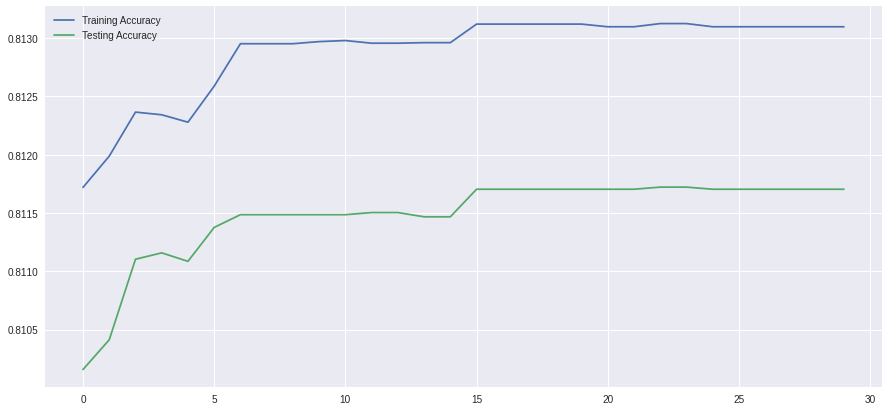

In [ ]:
classifiers = train_logitboost(X_train, y_train_alt, 30, 0.05, X_test, y_test, 1)

We see that there is a very slight increase in performance, and this is reached immediately at the beginning of training. A more in-depth analysis can be found in the model evaluation section.

## Model 5: Latent "Scores" model

The model aims to generate latent “scores” for each player’s attributes. A more positive score for a certain feature represents that the player has higher odds of scoring given that feature, and vice versa for negative scores.

This way, we can compare the scores between players to determine how good they are on each situation. For example, if player A has a right foot score of -0.5 and player B has a right foot score of 0.3, we can tell that player B is better at right footed shots compared to player A. 

We first initialize all the player scores to be 0 to represent that all players are “average” before any training is done. Eventually, the scores should deviate and reflect the ability of each player.


In [ ]:
from tqdm.auto import tqdm
epochs = 1000
learning_rate = 300

# theta_5 = np.tile(theta_2.reshape(1, -1), reps=(num_players, 1)) 
theta_5 = np.zeros((num_players, X_train.shape[1]))
# theta_5 = np.full((num_players, X_train.shape[1]), fill_value=-1.0)
# Initialize weights

@jit
def model5_predict(theta, X):
  indexes = X[:, -1].astype(int)
  thetas = theta[indexes, :]
  return sigmoid(np.sum(np.multiply(thetas, X[:, :-1]), axis=1))

@jit
def model5_loss(theta, X, y):

  preds = model5_predict(theta, X)

  return - np.mean(y * np.log(preds) + \
                 (1.0 - y) * np.log(1.0 - preds))
  
def model5_accuracy(theta, X, y, threshold=0.5):
  preds = model5_predict(theta, X)
  preds = (preds >= threshold)
  return accuracy_score(y, preds)


def model5_positive_accuracy(theta, X, y, threshold=0.5):
  preds = model5_predict(theta, X)
  preds = (preds >= threshold)
  return accuracy_score(y[y == 1], preds[y == 1])

@jit
def sgd_update(theta, X, y, learning_rate):

  grads = grad(model5_loss)(theta, X, y)
  return theta - (learning_rate * grads)

train_loss = [] # loss history 
train_accuracies = []
test_accuracies = []
theta_history = []
for i in tqdm(range(epochs)):
  if i % 50 == 0:
    theta_history.append(theta_5)
  theta_5 = sgd_update(theta_5, X_train_full, y_train, learning_rate)
  loss_tr = model5_loss(theta_5, X_train_full, y_train)
  train_loss.append(loss_tr)
  train_accuracy = model5_accuracy(theta_5, X_train_full, y_train, 0.5)
  test_accuracy = model5_accuracy(theta_5, X_test_full, y_test, 0.5)
  train_accuracies.append(train_accuracy)
  test_accuracies.append(test_accuracy)
  # print(i, loss_tr, train_accuracy, test_accuracy)
  


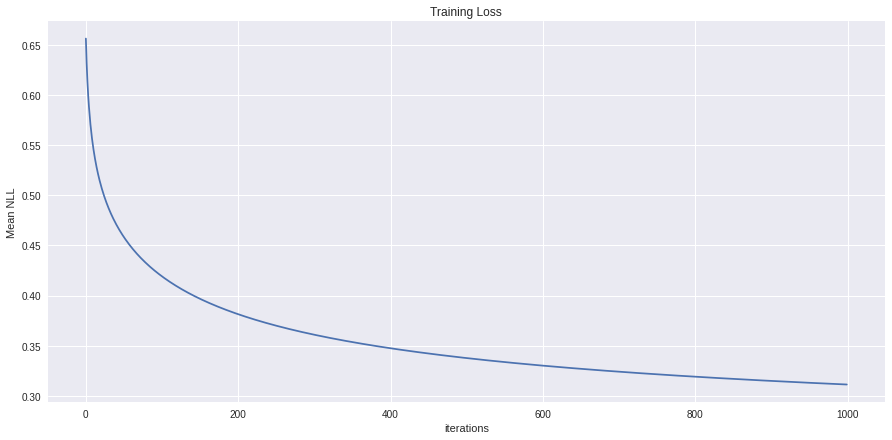

In [ ]:
plt.plot(onp.arange(epochs), train_loss)
plt.title("Training Loss")
plt.ylabel("Mean NLL"), plt.xlabel("iterations")
plt.show()

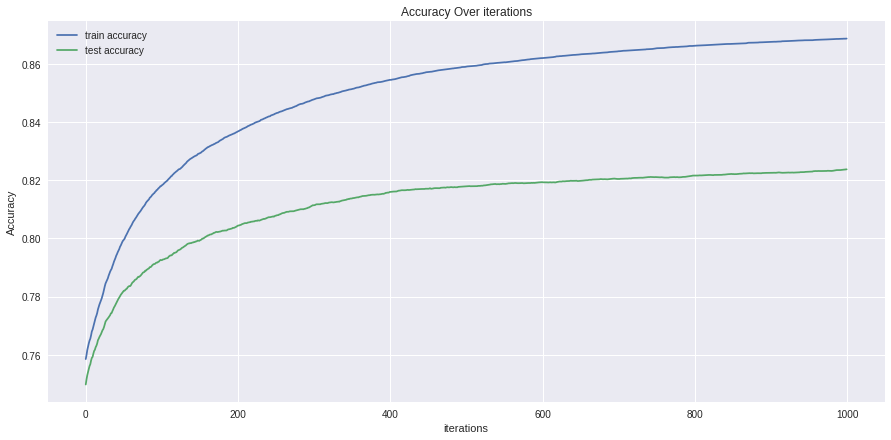

In [ ]:
plt.plot(onp.arange(epochs), train_accuracies, label="train accuracy")
plt.plot(onp.arange(epochs), test_accuracies, label="test accuracy")
plt.title("Accuracy Over iterations")
plt.ylabel("Accuracy")
plt.xlabel("iterations")
plt.legend()

# Model evaluation

### Model 5 Discussion


First, let's take a look at some player's scores.

In [ ]:
interpretation = ["intercept"] + data.columns[:-2].to_list()
def get_scores(theta, player_id):
  
  print(f"Player {player_id}, {id_to_player[player_id]}: ")
  print("\n".join([f"{i} {inter}: {theta[player_id, i]}" for i, inter in 
             enumerate(interpretation)]))

get_scores(theta_5, player_to_id["marek hamsik"])

Player 662, marek hamsik: 
0 intercept: -0.433421790599823
1 fast_break: 0.7418874502182007
2 loc_centre_box: 0.901131808757782
3 loc_diff_angle_lr: 0.0
4 diff_angle_left: 0.38454946875572205
5 diff_angle_right: 1.2107418775558472
6 left_side_box: -0.09218300133943558
7 left_side_6ybox: -0.6280595064163208
8 right_side_box: 0.18409737944602966
9 right_side_6ybox: 1.3979361057281494
10 close_range: 0.34398436546325684
11 penalty: -1.2954137325286865
12 outside_box: -1.379214882850647
13 long_range: -0.23838500678539276
14 more_35y: -1.2226099967956543
15 more_40y: 0.0
16 right_foot: 0.05065996199846268
17 left_foot: 0.29836493730545044
18 header: -0.782447338104248
19 no_assist: 0.32417789101600647
20 assist_pass: -0.3337034285068512
21 assist_cross: -0.7929799556732178
22 assist_header: -1.0348620414733887
23 assist_through_ball: 1.4039465188980103
24 open_play: -0.8075066208839417
25 set_piece: 1.4071922302246094
26 corner: -1.0331050157546997
27 free_kick: 0.0


From the scores above, we can see that this player is quite bad at penalties. In fact, a quick google search of "Marek Hamsik Penalty" leads to several articles/footages of him missing penalties. 

In [ ]:
get_scores(theta_5, player_to_id["lionel messi"])

Player 587, lionel messi: 
0 intercept: 0.8593194484710693
1 fast_break: 1.9230166673660278
2 loc_centre_box: -1.020300030708313
3 loc_diff_angle_lr: -2.216498851776123
4 diff_angle_left: -1.5500717163085938
5 diff_angle_right: -2.3394241333007812
6 left_side_box: -2.035839080810547
7 left_side_6ybox: 0.5426537394523621
8 right_side_box: -1.6864145994186401
9 right_side_6ybox: -0.515513002872467
10 close_range: 1.3193342685699463
11 penalty: 0.18065211176872253
12 outside_box: -2.828068256378174
13 long_range: -1.0742733478546143
14 more_35y: 0.0
15 more_40y: 0.0
16 right_foot: 0.5619924664497375
17 left_foot: 0.3520219624042511
18 header: -0.05469411611557007
19 no_assist: 0.03653969615697861
20 assist_pass: 0.44771555066108704
21 assist_cross: -0.1856054961681366
22 assist_header: -0.8380264043807983
23 assist_through_ball: 1.3986942768096924
24 open_play: -0.680970311164856
25 set_piece: 0.7445467114448547
26 corner: 0.8988022208213806
27 free_kick: -0.10305851697921753


We can see that the best player in the world Lionel Messi has a very high intercept. This means that he has a high base probability to score. We can also tell that he is dangerous on the fast break, and that he is good with either feet. However, his heading is not that great.

In [ ]:
for i in range(theta_5.shape[1]):
  best = theta_5[:, i].argmax()
  worst = theta_5[:, i].argmin()
  print(f"Best player for {interpretation[i]} is: {id_to_player[int(best)]}")
  print(f"Worst player for {interpretation[i]} is: {id_to_player[int(worst)]}\n")

Best player for intercept is: clement grenier
Worst player for intercept is: rene krhin

Best player for fast_break is: franco vazquez
Worst player for fast_break is: tommaso rocchi

Best player for loc_centre_box is: florent balmont
Worst player for loc_centre_box is: jose fonte

Best player for loc_diff_angle_lr is: silvan widmer
Worst player for loc_diff_angle_lr is: cristiano ronaldo

Best player for diff_angle_left is: gonzalo bergessio
Worst player for diff_angle_left is: gonzalo higuain

Best player for diff_angle_right is: opa nguette
Worst player for diff_angle_right is: lionel messi

Best player for left_side_box is: mehdi zeffane
Worst player for left_side_box is: marko arnautovic

Best player for left_side_6ybox is: ronny rodelin
Worst player for left_side_6ybox is: claudio pizarro

Best player for right_side_box is: bobby zamora
Worst player for right_side_box is: anthony modeste

Best player for right_side_6ybox is: sebastien corchia
Worst player for right_side_6ybox is: 

The model seems to suffer from a form of survivorship bias. For example, Cristiano Ronaldo often attempts long range shots (which more often than not miss), and thus his long range score decreases. 

However, his actual long range shot abilities are quite good; this is not reflected in the model due to the fact that most players do not attempt long range goals.

That is, the model is not good at knowing what a player is _bad_ at. However, the model is pretty accurate at knowing what a player is _good_ at. 

Most of the "best player for __" makes sense. Cristiano ronaldo is known to be a lethal penalty taker. Searching for Marvin plattenhardt results in such [videos](https://www.youtube.com/watch?v=pdQRzH1htxI).

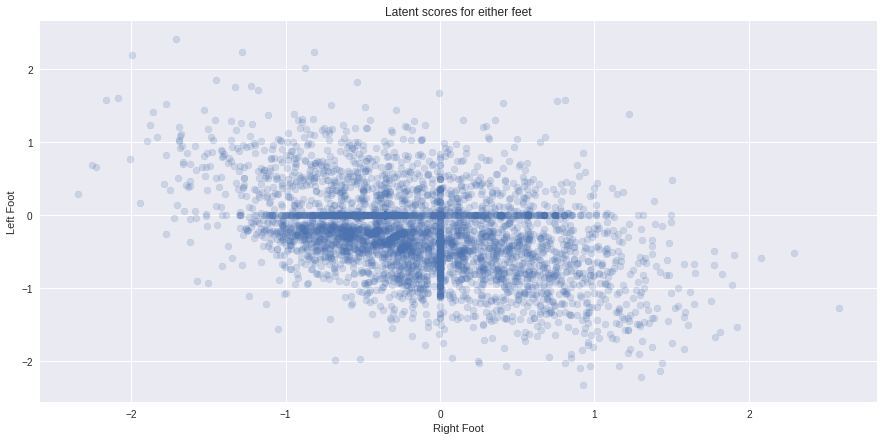

In [ ]:
plt.scatter(theta_5[:, 16], theta_5[:, 17], alpha=0.2)
plt.xlabel("Right Foot"), plt.ylabel("Left Foot")
plt.title("Latent scores for either feet")
plt.show()

There is some evidence that the model works as intended, however. We can see that generally, players with a good left foot have bad right feet and vice versa. This follows our general intuition. 

Likewise, there are a few outliers who are good with either feet. This is reflected in reality where some players are ambidextrous.

We can also see that there is some concentration on the axis. This means that some players only shoot with either their left or right exclusively in the dataset.

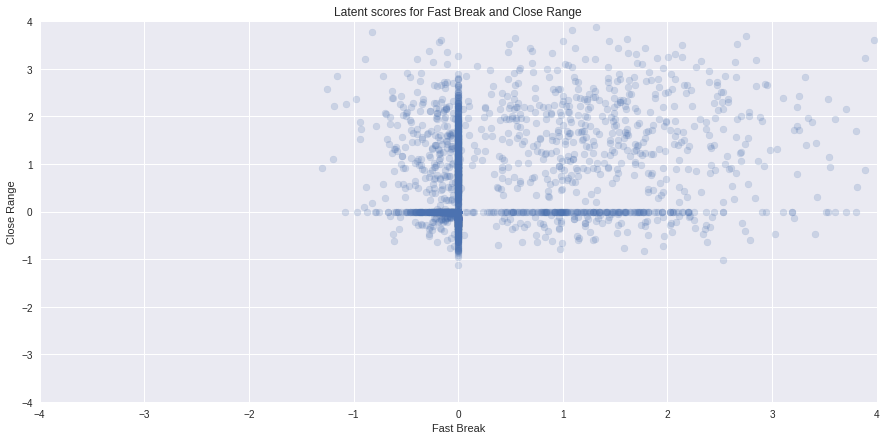

In [ ]:
# pd.DataFrame(theta_5).corr().iloc[1]
plt.scatter(theta_5[:, 1], theta_5[:, 10], alpha=0.2)
plt.xlabel("Fast Break"), plt.ylabel("Close Range")
plt.title("Latent scores for Fast Break and Close Range")
plt.xlim(-4, 4), plt.ylim(-4, 4)
plt.show()

In this example, we can see that players that are better on a fast break (a counter attack) are generally also better at close range. 

It's interesting to see that very few players have negative scores for both close range and a fast break. We can conclude that in general, having a close range shot or being in a counter attack gives you better odds of scoring.

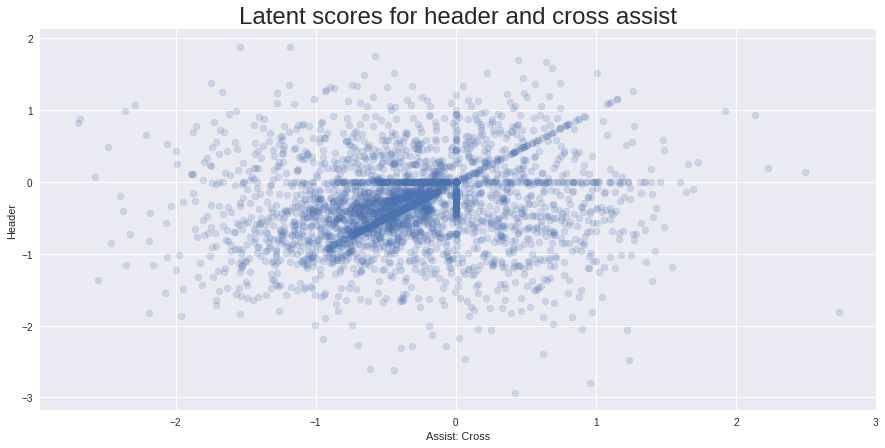

In [ ]:
plt.scatter(theta_5[:, 21], theta_5[:, 18], alpha=0.2)
plt.xlabel("Assist: Cross"), plt.ylabel("Header")
plt.title("Latent scores for header and cross assist", fontsize=24)
plt.show()

Here we can see that generally, players that are score more often with headers also score more often when assisted with a cross. This makes intuitive sense, as most header chances are created from a cross. 

This is also reflected in the clear concentration around the $y=x$ line.

In [ ]:
stds = theta_5.std(axis=0)
print("Standard Deviations for each feature across players: ")
for i in range(len(interpretation)):
  print(f"{i} {interpretation[i]} std: {stds[i]}")

Standard Deviations for each feature across players: 
0 intercept std: 0.4546653628349304
1 fast_break std: 0.6395930647850037
2 loc_centre_box std: 0.7170272469520569
3 loc_diff_angle_lr std: 0.23287001252174377
4 diff_angle_left std: 0.3088882565498352
5 diff_angle_right std: 0.2898409962654114
6 left_side_box std: 0.5355175137519836
7 left_side_6ybox std: 0.42936015129089355
8 right_side_box std: 0.5333548784255981
9 right_side_6ybox std: 0.4371338486671448
10 close_range std: 0.7894700169563293
11 penalty std: 0.44185614585876465
12 outside_box std: 0.8148666024208069
13 long_range std: 0.23955780267715454
14 more_35y std: 0.218282550573349
15 more_40y std: 0.07903074473142624
16 right_foot std: 0.5905227065086365
17 left_foot std: 0.536469042301178
18 header std: 0.5012468695640564
19 no_assist std: 0.6208637356758118
20 assist_pass std: 0.5730043649673462
21 assist_cross std: 0.5538914799690247
22 assist_header std: 0.42966899275779724
23 assist_through_ball std: 0.47728657722473

It might be reasonable to assume that features with a huge variance indicate that the feature is more important. Intuitively, a larger variance indicates that we are able to determine the probability of scoring due to that feature being present more accurately between players. On the other hand, a smaller variance indicates that the features matters less in the probability of scoring.

In [ ]:
avgs = theta_5.mean(axis=0)
print("Means for each feature across players: ")
for i in range(len(interpretation)):
  print(f"{i} {interpretation[i]} avg: {avgs[i]}")

Means for each feature across players: 
0 intercept avg: -0.6134137511253357
1 fast_break avg: 0.20388838648796082
2 loc_centre_box avg: -0.002618784550577402
3 loc_diff_angle_lr avg: -0.052668724209070206
4 diff_angle_left avg: -0.05038480460643768
5 diff_angle_right avg: -0.054746706038713455
6 left_side_box avg: -0.23092156648635864
7 left_side_6ybox avg: 0.03358176350593567
8 right_side_box avg: -0.21509148180484772
9 right_side_6ybox avg: 0.03469127416610718
10 close_range avg: 0.3636508285999298
11 penalty avg: 0.12967051565647125
12 outside_box avg: -0.8108180165290833
13 long_range avg: -0.06266151368618011
14 more_35y avg: -0.06736897677183151
15 more_40y avg: -0.010400678962469101
16 right_foot avg: -0.14193928241729736
17 left_foot avg: -0.23964929580688477
18 header avg: -0.23182517290115356
19 no_assist avg: -0.08747075498104095
20 assist_pass avg: -0.2968837022781372
21 assist_cross avg: -0.2491430640220642
22 assist_header avg: -0.08143193274736404
23 assist_through_ball

We might also investigate the average scores of each feature. A high average score means that players are really likely to score given that feature, and a low average score means that players are unlikely to score given that feature. This might give us insight into what situations lead to better goal scoring opportunities.

Based on the results above, penalties and fastbreaks, and close ranges have the highest averages. This makes intuitive sense, as these three situations cause a majority of the goals.

### Model Comparisons

In [ ]:
model1_preds = bern_predict(theta_1, X_test_full)

model2_preds = logreg_pred(theta_2, X_test)
model2_preds = model2_preds >= 0.5

model4_preds = predict_logitboost(X_test, classifiers)
y_test_alt = onp.copy(y_test)
y_test_alt[y_test_alt == 0] = -1

model5_preds = model5_predict(theta_5, X_test_full)
model5_preds = model5_preds >= 0.5

pd.DataFrame.from_dict(
             {
              "Bernoulli": get_metrics(y_test, model1_preds),
              "Logistic Regression": get_metrics(y_test, model2_preds),
              "LogitBoost": get_metrics(y_test_alt, model4_preds),
              "Latent Variable Log. Reg.": get_metrics(y_test, model5_preds)
              },
             columns=
             ["Accuracy", "Balanced Accuracy", "Precision (1)", "Recall (1)", "F1 Score"], 
             orient="index")

,Accuracy,Balanced Accuracy,Precision (1),Recall (1),F1 Score
Bernoulli,0.643082,0.531152,0.302220,0.301962,0.302091
Logistic Regression,0.798120,0.639843,0.750591,0.315752,0.444511
LogitBoost,0.811703,0.669891,0.766547,0.379514,0.507678
Latent Variable Log. Reg.,0.823814,0.732677,0.699317,0.546062,0.613260


## Model Conclusions

All the models aim to predict the result of a shot given the situation, i.e a long ranged, right footed shot from a cross. For model 5 specifically, we assume that different players in the same situation have different probabilities of scoring. Furthermore, all the models assume that the probabilities of scoring are independent with respect to time. This is reflected with the way we split our train/test data, as we randomly split with disregard for the data of the match. In the future, we would like to explore the possibility of doing a time-series dependant model to simulate the growth/regression of players’ ability.

We chose to use the F1 score as the base metric for evaluating our models because we want our models to correctly capture as many positive targets as possible while not incorrectly classifying attempts that did not result in goals as goals. As we can see from the table in model comparisons, model 5 has the best F1 score, i.e it strikes the best balance between precision and recall. However, we note that the precision of model 5 is the worst out of all the models we implemented. This may suggest that our model is overly “optimistic”. In other words, it predicts goals when there are none more frequently compared to the other models.
However, due to this “optimistic” behavior, it also discovers goals more often compared to the other models. As always in machine learning, there is a tradeoff to be had. 

Model 4, the LogitBoost model, shows a slight increase in performance across all metrics over its main component - logistic regression. However, because boosting had such a small effect, this could possibly suggest that such simple methods have achieved their peak and more complicated solutions are necessary. This is supported by the results for model 5, which introduced latent features and was able to obtain a much better F1 score. It is thus probable that even more complex methods such as neural networks can show further improvement and should be the target of further investigation. Still, we see that model 4 achieved the best precision score. That is, it had the least false positives on the test set. This is encouraging news as the motivation behind this model was to deal with the target imbalance, suggesting that similar techniques could be utilized in further more complicated models.

Our models needs to be trained on new data as the season progresses, as the ability of players change as they improve/regress over time. Adding new data will improve the accuracy of its predictions. If possible, we can use data from everyday training to better evaluate the performance of our own players. This way, we can determine which situations to focus on.

New players in the competition would also harm the model accuracy. This may occur if a new young player makes their debut, or a player with no data (i.e from another league, such as the Netherlands’ Eredivisie). In these situations, model 5 will not work well as they will assume a score of 0 on each feature. To compensate for this, we can use model 4 as the baseline until we have enough data on the new player. 


As a simulation of how we can use the models, let's assume that we are playing against Manchester City. We're worried about their star striker, Sergio Aguero.

In [ ]:
get_scores(theta_5, player_to_id["sergio aguero"])

Player 2669, sergio aguero: 
0 intercept: -0.09064381569623947
1 fast_break: 2.6993649005889893
2 loc_centre_box: 0.13901351392269135
3 loc_diff_angle_lr: 0.0
4 diff_angle_left: -0.47161003947257996
5 diff_angle_right: 0.622063398361206
6 left_side_box: -1.0746248960494995
7 left_side_6ybox: -0.8403605818748474
8 right_side_box: -0.5447885394096375
9 right_side_6ybox: -0.8622183203697205
10 close_range: 2.0008509159088135
11 penalty: 1.3515571355819702
12 outside_box: -0.4105239808559418
13 long_range: 0.0
14 more_35y: 0.0
15 more_40y: 0.0
16 right_foot: 0.045496489852666855
17 left_foot: 0.15234272181987762
18 header: -0.28848370909690857
19 no_assist: -0.2713075876235962
20 assist_pass: -0.8534502983093262
21 assist_cross: -0.7964633703231812
22 assist_header: 0.5944206714630127
23 assist_through_ball: 1.2361547946929932
24 open_play: -0.2825864851474762
25 set_piece: 0.9761930704116821
26 corner: -0.7842515110969543
27 free_kick: 0.0


In [ ]:
print("Model 2 feature weights")
for i in range(len(interpretation)):
  print(f"{i} {interpretation[i]}: {theta_2[i]}")

Model 2 feature weights
0 intercept: -0.205155149102211
1 fast_break: 0.7444966435432434
2 loc_centre_box: 0.2422608584165573
3 loc_diff_angle_lr: -0.14645175635814667
4 diff_angle_left: -0.10165217518806458
5 diff_angle_right: -0.11366835981607437
6 left_side_box: -0.5583844184875488
7 left_side_6ybox: 0.1791139841079712
8 right_side_box: -0.5407630801200867
9 right_side_6ybox: 0.1802084743976593
10 close_range: 1.2482861280441284
11 penalty: 0.6326953172683716
12 outside_box: -1.7255384922027588
13 long_range: -0.18084925413131714
14 more_35y: -0.1949073076248169
15 more_40y: -0.028670016676187515
16 right_foot: 0.19347567856311798
17 left_foot: 0.019366197288036346
18 header: -0.41761910915374756
19 no_assist: 0.05407765507698059
20 assist_pass: -0.2141290158033371
21 assist_cross: -0.41925960779190063
22 assist_header: -0.11567626893520355
23 assist_through_ball: 0.4901662766933441
24 open_play: -0.5840131044387817
25 set_piece: 0.4537377655506134
26 corner: -0.10327203571796417
27

If we used model 2, we wouldn't have realized that Sergio Aguero is really good on difficult angle at the right, and much more dangerous than average on close range. 

Assume that he has a 60% chance to score given that the shot was at close range, and that he has 6 shots in close range in a game. If using the knowledge from the model we can reduce his close range opportunities by half, we can prevent a goal in average. This can be the key to converting draws to victories.

Furthermore, we want to do some analysis on our own players. For this example, let's assume we are Liverpool, and we want to see how our striker Daniel Sturridge fares.

In [ ]:
get_scores(theta_5, player_to_id["daniel sturridge"])

Player 2657, daniel sturridge: 
0 intercept: 0.6279808878898621
1 fast_break: 1.7062275409698486
2 loc_centre_box: -1.1144732236862183
3 loc_diff_angle_lr: 0.0
4 diff_angle_left: 0.5157669186592102
5 diff_angle_right: 1.764822006225586
6 left_side_box: -0.42314276099205017
7 left_side_6ybox: 0.6887977123260498
8 right_side_box: -1.8139846324920654
9 right_side_6ybox: -0.17262616753578186
10 close_range: 3.1225454807281494
11 penalty: 0.0
12 outside_box: -0.7635222673416138
13 long_range: -0.6319053173065186
14 more_35y: -0.5442934632301331
15 more_40y: 0.0
16 right_foot: -0.8707075715065002
17 left_foot: -0.38584646582603455
18 header: 1.8845328092575073
19 no_assist: 0.7220109701156616
20 assist_pass: -0.5433411002159119
21 assist_cross: -1.182913064956665
22 assist_header: -0.47370365262031555
23 assist_through_ball: 2.105926990509033
24 open_play: -0.9382092356681824
25 set_piece: 2.7913575172424316
26 corner: -0.08513230085372925
27 free_kick: -1.14003324508667


We can see that our striker needs to improve furhter on their shooting skills with their feet. However, we note that his header is excellent! We should try to cross the ball to Sturridge more to take advantage of his good header. We also see that he is devastating at the through ball and at close range. 

We can now form a strategy: we can keep sturridge at a high line so that he can be ready for the counter attack, and this allows players to give him a through ball and to get into close range. Alternatively, we can set it up so that our players will try to spot him and cross the ball to setup the header. 

Assuming that he scores 10% more header attempts, and 50% of crosses meet their target, we can assume that we can score an additional goal for every 20 crosses we play to Sturridge. With great defending against Sergio Aguero by forcing him away from his preferred right side of the box, and great crosses into Daniel Sturridge, we might win the match! 